In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import os
import json
import numpy as np
import random
from tqdm.notebook import tqdm
from torchvision.transforms import functional as FN
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchsummary import summary
from torch.utils.data._utils.collate import default_collate
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Subset

from time import time
from IPython.display import clear_output

In [2]:
folder_path = 'Potholes/annotated-images'

In [3]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.iter('object'):
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        ymin = int(xmlbox.find('ymin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymax = int(xmlbox.find('ymax').text)
        boxes.append((xmin, ymin, xmax, ymax))
    
    return boxes


In [ ]:
# Function to display image with bounding boxes
def display_image_with_boxes(image_path, boxes):
    # Open the image file
    img = Image.open(image_path)
    # Create a figure and axis for the image
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(img)

    # Add the bounding boxes
    for xmin, ymin, xmax, ymax in boxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

# Function to display only n images with bounding boxes
def display_n_images(n):
    count = 0
    # Read all png files and corresponding xml files in the folder
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.jpg') and count < n:
            image_file = os.path.join(folder_path, file)
            xml_file = os.path.join(folder_path, file.replace('.jpg', '.xml'))

            # Check if the XML file exists
            if os.path.exists(xml_file):
                # Parse the XML file to get bounding box coordinates
                boxes = parse_annotation(xml_file)
                # Display the image with bounding boxes
                display_image_with_boxes(image_file, boxes)
                count += 1

In [ ]:
# Call the function to display n images
display_n_images(2)  #

In [ ]:
def selective_search(image_path):
    # Load image
    img = cv2.imread(image_path)
    # Convert image to RGB (OpenCV uses BGR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img_rgb)

    # Switch to fast mode
    ss.switchToSelectiveSearchFast()

    # Run selective search
    rects = ss.process()

    return img_rgb, rects

def edge_boxes(image_path):
    # Load image
    img = cv2.imread(image_path)
    
    # Ensure the image is in color
    if len(img.shape) != 3 or img.shape[2] != 3:
        raise ValueError("Input must be a color image")

    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert image to 32-bit floating point
    img_float = np.float32(img) / 255.0

    # Create Edge Boxes object
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection("model.yml.gz")
    edges = edge_detection.detectEdges(img_float)

    # Create Orientation Map
    orimap = edge_detection.computeOrientation(edges)

    # Create and configure Edge Boxes
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(100)
    edge_boxes.setAlpha(0.65)
    edge_boxes.setBeta(0.75)
    edge_boxes.setEta(1)
    edge_boxes.setMinScore(0.01)

    # Get boxes
    boxes, _ = edge_boxes.getBoundingBoxes(edges, orimap)

    return img, boxes

In [ ]:
def display_image_with_boxes(img, boxes, method_name):
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    print("Number of Boxes: ", len(boxes))
    for box in boxes:
        # Ensure the box coordinates are in the correct format
        x, y, w, h = box
        if isinstance(x, np.ndarray):
            x = x[0]
        if isinstance(y, np.ndarray):
            y = y[0]
        if isinstance(w, np.ndarray):
            w = w[0]
        if isinstance(h, np.ndarray):
            h = h[0]

        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.title(f"Object Proposals using {method_name}")
    plt.show()

In [ ]:
image_path = 'Potholes/annotated-images/img-501.jpg'

# Selective Search
img_rgb, rects = selective_search(image_path)
display_image_with_boxes(img_rgb, rects, "Selective Search")

# Edge Boxes
img_rgb, boxes = edge_boxes(image_path)
display_image_with_boxes(img_rgb, boxes, "Edge Boxes")

In [ ]:
def calculate_iou(ground_truth, proposed_box):
    xmin_gt, ymin_gt, xmax_gt, ymax_gt = ground_truth
    x_proposed, y_proposed, width_proposed, height_proposed = proposed_box

    # Calculate the coordinates of the intersection rectangle
    x1_intersection = max(xmin_gt, x_proposed)
    y1_intersection = max(ymin_gt, y_proposed)
    x2_intersection = min(xmax_gt, x_proposed + width_proposed)
    y2_intersection = min(ymax_gt, y_proposed + height_proposed)

    # Calculate the area of the intersection rectangle
    intersection_area = max(0, x2_intersection - x1_intersection) * max(0, y2_intersection - y1_intersection)

    # Calculate the area of the ground truth and proposed bounding boxes
    ground_truth_area = (xmax_gt - xmin_gt) * (ymax_gt - ymin_gt)
    proposed_box_area = width_proposed * height_proposed

    # Calculate the Union area
    union_area = ground_truth_area + proposed_box_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou



In [ ]:
box1 = [20, 30, 100, 150]  # [x_min, y_min, width, height]
box2 = [60, 70, 110, 160]

iou = calculate_iou(box1, box2)
print(f"Intersection over Union: {iou}")

In [ ]:
image_path = 'Potholes/annotated-images/img-501.jpg'
source_path = "Potholes/annotated-images/img-501.xml"
ground_truth_boxes = parse_annotation(source_path)
# Selective Search
#img_rgb, rects = selective_search(image_path)
img_rgb, boxes = edge_boxes(image_path)

In [ ]:
# Define the IoU threshold
iou_threshold = 0.7

# Plot the image with boxes
fig, ax = plt.subplots(1)
ax.imshow(img_rgb)
print("Number of proposed boxes: ", len(boxes))
# Plot ground truth boxes in green
print("Ground truth boxes: ", len(ground_truth_boxes))
for xmin, ymin, xmax, ymax in ground_truth_boxes:
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

# Iterate through selective search boxes and add those with IoU > threshold

count= 0
for box in rects:
    for gt_box in ground_truth_boxes:
        iou = calculate_iou(gt_box, box)
        if iou > iou_threshold:
            count+=1
            x, y, w, h = box
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

print("Fitting Boxes: ", count)
plt.title("Object Proposals with IoU > 0.7")
plt.show()

In [ ]:
def process_images(image_dir):
    iou_threshold_high = 0.7
    iou_threshold_low = 0.3
    all_data = []

    for file in os.listdir(image_dir):
        if file.endswith('.jpg'):
            image_path = os.path.join(image_dir, file)
            xml_path = os.path.join(image_dir, file.replace('.jpg', '.xml'))

            # Parse annotations and perform edge boxes
            ground_truth_boxes = parse_annotation(xml_path)
            img_rgb, boxes = edge_boxes(image_path)

            labeled_boxes = []
            for box in boxes:
                label = None
                for gt_box in ground_truth_boxes:
                    iou = calculate_iou(gt_box, box)
                    if iou > iou_threshold_high:
                        label = 1  # Label as 1 (pothole) if IoU is high
                        break
                    elif iou < iou_threshold_low:
                        label = 0  # Label as 0 (not a pothole) if IoU is low

                # Append the box and its label only if it's labeled (either 0 or 1)
                if label is not None:
                    box_list = [int(coord) for coord in box]
                    labeled_boxes.append({'box': box_list, 'label': label})

            # Add the results for the current image to the all_data list
            all_data.append({'image': image_path, 'boxes': labeled_boxes})

    # Save all results at once
    save_results(all_data)

def save_results(all_data):
    # Write the data to a JSON file
    json_file_name = 'processed_images_data.json'
    with open(json_file_name, 'w') as outfile:
        json.dump(all_data, outfile, indent=4)

In [ ]:
process_images('Potholes/annotated-images')

In [ ]:
def split_dataset(image_dir, json_file, train_ratio=0.8, val_ratio=0.1):
    all_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    random.shuffle(all_files)

    num_total = len(all_files)
    num_train = int(num_total * train_ratio)
    num_val = int(num_total * val_ratio)

    train_files = all_files[:num_train]
    val_files = all_files[num_train:num_train + num_val]
    test_files = all_files[num_train + num_val:]

    # Update JSON file with subset information
    with open(json_file, 'r') as f:
        data = json.load(f)

    for item in data:
        file_name = os.path.basename(item['image'])
        if file_name in train_files:
            item['subset'] = 'train'
        elif file_name in val_files:
            item['subset'] = 'val'
        else:
            item['subset'] = 'test'

    # Write updated data back to JSON file
    with open(json_file, 'w') as f:
        json.dump(data, f, indent=4)

# Call the function
split_dataset('Potholes/annotated-images', 'processed_images_data.json')


In [3]:
class PotholeDataset(Dataset):
    def __init__(self, json_file, transform=None, target_transform=None, subset=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)

        self.transform = transform
        self.target_transform = target_transform
        self.subset = subset
        self.cropped_data = []
        self.prepare_dataset()

        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),  # Rotate by ±20 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            self.random_noise
        ])

    def random_noise(self, img):
        if random.random() < 0.5:  # 50% chance to add noise
            noise = torch.randn(img.size()) * 0.05
            img = img + noise
            img = torch.clamp(img, 0, 1)
        return img

    def prepare_dataset(self):
        for item in self.data:
            if self.subset is not None and item.get('subset') != self.subset:
                continue
            image_path = item['image']
            image = Image.open(image_path).convert('RGB')
            for box_info in item['boxes']:
                box = box_info['box']
                label = box_info['label']
                cropped_image = FN.crop(image, box[1], box[0], box[3], box[2])  # top, left, height, width
                if self.transform:
                    cropped_image = self.transform(cropped_image)
                self.cropped_data.append((cropped_image, label))

    def __len__(self):
        return len(self.cropped_data)

    def __getitem__(self, idx):
        image, label = self.cropped_data[idx]


        # Check if the label is positive (1), and apply augmentations if so
        if label == 1:
            image = self.augment_transform(image)

        return image, label

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
with open('processed_images_data.json', 'r') as file:
    data = json.load(file)

count_negative_class_samples = 0
count_positive_class_samples = 0

# Iterate through the data and count the labels
for entry in data:
    for box in entry['boxes']:
        if box['label'] == 0:
            count_negative_class_samples += 1
        elif box['label'] == 1:
            count_positive_class_samples += 1

print("Negative class samples count:", count_negative_class_samples)
print("Positive class samples count:", count_positive_class_samples)

Negative class samples count: 61979
Positive class samples count: 757


In [6]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the cropped images
    transforms.ToTensor()
])


train_dataset = PotholeDataset(json_file='processed_images_data.json', transform=transform, subset='train')

# Calculate weights for each sample
class_counts = [count_negative_class_samples, count_positive_class_samples]  # You need to calculate these counts
class_weights = [1.0/count for count in class_counts]
weights = [class_weights[train_dataset[i][1]] for i in range(len(train_dataset))]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

# Use the sampler in the DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, sampler=sampler, num_workers=3)

test_dataset = PotholeDataset(json_file='processed_images_data.json', transform=transform, subset='test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=3)



### Normal
#train_dataset = PotholeDataset(json_file='processed_images_data.json', transform=transform, subset='train')
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)

#test_dataset = PotholeDataset(json_file='processed_images_data.json', transform=transform, subset='test')
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=3)

In [6]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the cropped images
    transforms.ToTensor()
])

train_dataset = PotholeDataset(json_file='processed_images_data.json', transform=transform, subset='train')

# Separate indices for negative and positive class samples
negative_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 0]
positive_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 1]

# Randomly downsample negative class
random.shuffle(negative_indices)
downsampled_negative_indices = negative_indices[:len(positive_indices)]

# Combine positive and downsampled negative indices
balanced_indices = downsampled_negative_indices + positive_indices
random.shuffle(balanced_indices)  # Shuffle to mix positive and negative samples

# Create a subset of the dataset using the balanced indices
balanced_train_dataset = Subset(train_dataset, balanced_indices)

# DataLoader using the balanced dataset
train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True, num_workers=3)

test_dataset = PotholeDataset(json_file='processed_images_data.json', transform=transform, subset='test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=3)

In [9]:
images, labels = next(iter(test_loader))
print (len(images))
plt.figure(figsize=(20,10))

count = 0
# Assuming 'labels' is a tensor containing the labels for the images
for minibatch_no, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
    
# Count the number of labels that are equal to 1
    count += (target == 1).sum().item()

# Printing the count
print("Number of labels equal to 1:", count)


64


  0%|          | 0/98 [00:00<?, ?it/s]

Number of labels equal to 1: 80


<Figure size 2000x1000 with 0 Axes>

64


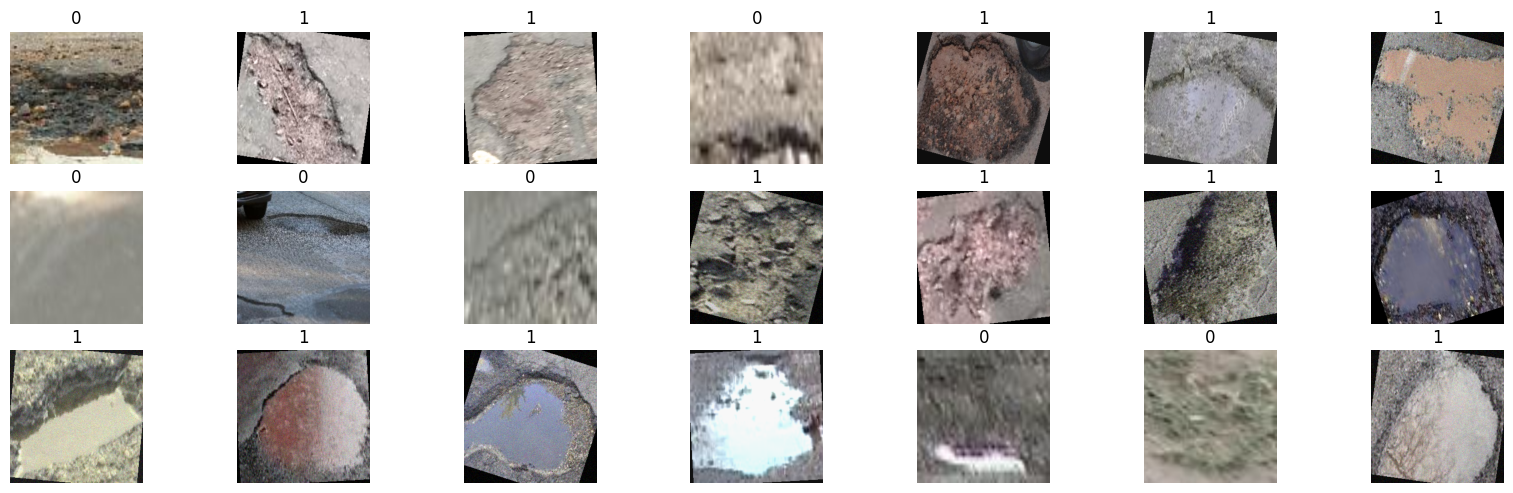

In [12]:
images, labels = next(iter(train_loader))
print (len(images))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['0', '1'][labels[i].item()])
    plt.axis('off')


In [7]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target) 
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = nn.CrossEntropyLoss()(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(nn.CrossEntropyLoss()(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(train_dataset))
        out_dict['test_acc'].append(test_correct/len(train_dataset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [11]:
model_ft = models.resnet50()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_adam = torch.optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0.01)
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 7.12 MiB is free. Process 17407 has 1.36 GiB memory in use. Process 2497 has 2.34 GiB memory in use. Process 3465 has 1.03 GiB memory in use. Process 30648 has 2.26 GiB memory in use. Process 10503 has 4.88 GiB memory in use. Including non-PyTorch memory, this process has 3.89 GiB memory in use. Of the allocated memory 3.52 GiB is allocated by PyTorch, and 2.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
out_dict = train(model_ft, optimizer_adam, num_epochs=50)

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/19 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 53.12 MiB is free. Process 17407 has 1.36 GiB memory in use. Process 2497 has 2.34 GiB memory in use. Process 3465 has 1.03 GiB memory in use. Process 30648 has 2.26 GiB memory in use. Process 10503 has 4.88 GiB memory in use. Including non-PyTorch memory, this process has 3.84 GiB memory in use. Of the allocated memory 3.45 GiB is allocated by PyTorch, and 28.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
images, labels = next(iter(train_loader))
images = images.to(device)
pred= model_ft(images)

In [18]:
print(pred)
print(labels)

tensor([[ 2.5942, -2.6197],
        [ 2.3265, -2.2766],
        [ 2.7305, -2.8046],
        [ 2.7774, -2.7688],
        [ 0.8878, -0.8588],
        [ 2.6126, -2.3698],
        [ 1.0299, -1.1153],
        [ 0.9376, -0.9992],
        [ 2.0715, -2.0813],
        [ 2.5467, -2.5012],
        [ 0.8207, -0.7711],
        [ 0.5220, -0.4743],
        [ 2.7833, -2.8280],
        [ 2.1558, -2.1850],
        [ 2.5926, -2.5576],
        [ 2.4494, -2.5088],
        [ 1.9478, -1.9385],
        [ 2.1059, -1.9609],
        [ 2.2455, -2.2778],
        [ 1.7557, -1.7603],
        [ 2.1420, -2.2122],
        [ 1.6358, -1.6377],
        [ 1.4296, -1.6165],
        [ 2.1715, -2.0126],
        [ 0.7089, -0.7983],
        [ 2.3998, -2.5699],
        [ 2.0080, -2.2461],
        [ 2.5052, -2.5074],
        [ 3.3277, -3.2418],
        [ 1.0782, -1.0963],
        [ 0.9953, -0.8950],
        [ 1.3830, -1.3318],
        [ 1.8727, -1.8401],
        [ 0.2256, -0.3440],
        [ 2.2399, -2.2015],
        [ 2.3151, -2